In [1]:
import subprocess
import sys


#!/home/selfetni/anaconda3/bin/python3.9.19
#print("PYTHON VERSION: ",sys.version)
# Install pyDOE using pip
subprocess.call(['pip', 'install', 'pyDOE'])

#!pip install pyDOE


import datetime, os
#hide tf logs 
os.environ['TF_CPPclea_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
import psutil # memory usage
from pyDOE import lhs         #Latin Hypercube Sampling

import codecs, json  # save weights
import math
import glob
#from numba import jit
# generates same random numbers each time
np.random.seed(1234)

import random
import datetime
import shutil

import random
import scipy.io as sio
from importlib import reload


import PINN  # python files (classes)
import pre_post
from pre_post import *
from PINN import *


2023-09-11 09:17:59.356097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 09:17:59.376549: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 09:17:59.376990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 09:18:02.695354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
##################################################
##################################################
##################################################
if __name__ == '__main__':     ###################
##################################################
##################################################
##################################################    
    #inputs = read_inputs_from_file("Input.txt")

    # Grid parameters
    Nx=101
    Ny=101
    Nt=1000  # 500 if los_f
 
    # Define the domain bounds
    lb = np.array([0, 0,0])
    ub = np.array([1, 1,1]) #np.array([Nx, Ny,Nt])
    dx = 1 #(ub[0] - lb[0]) / (Nx - 1)
    dy = 1 #(ub[1] - lb[1]) / (Ny - 1)
    
    # phyisical parameters
    sigma= 2
    mu= 1e-2
    eta=4*dx  # good value 3.5
    delta_g= -40

 
    
    num_phases=4
    loc_index_0 = 0
    loc_index_1 = 1
    loc_index_2 = 2
    loc_index_3 = 3
    all_phases_indexes= [loc_index_0, loc_index_1, loc_index_2, loc_index_3]
    
    N_batches=64      # base of the pyramid
    min_batch_numbers =4 # upper surface of the pyramid
    # Training batch 
    Nbr_f_pts_max_per_batch= 1000 #1000
    Nbr_f_pts_min_per_batch= 100 #100
    N_ini_max_per_batch=25 #50   
    N_ini_min_per_batch= 2 #4      
    fraction_ones_per_int_pts=0.35
    coef_increase_points_f=3 # or decrease
    coef_increase_points_ic=1.5 # or decrease

    num_train_intervals=Nt
    # Define  Collocations, IC and BC points and Domain bounds
    N_ini =N_batches *num_train_intervals # Total number of data points for 'phi': IC
    N_f = Nbr_f_pts_max_per_batch * N_batches *num_train_intervals    # 100000 Total number of collocation points : domain
    N_b=N_batches*Nt   # Total number of data points for boundary BC
        
    # Total number of data points for 'phi': boundary BC

    x = np.unique(np.linspace(lb[0], ub[0], Nx))
    y = np.unique(np.linspace(lb[1], ub[1], Ny))
    t = np.unique(np.linspace(lb[2], ub[2], Nt))
    f_values = [0, 0.33, 0.67, 1]

    # Generate all combinations of x, y, t, and f
    X, Y, T, F = np.meshgrid(np.linspace(lb[0], ub[0], Nx),
                            np.linspace(lb[1], ub[1], Ny),
                            np.linspace(lb[2], ub[2], Nt),
                            f_values,
                            indexing='ij')

    # Reshape the arrays to create the test matrix
    # = np.column_stack((X.flatten(), Y.flatten(), T.flatten(), F.flatten()))
    #np.savez('X_phi_test.npz', X_phi_test=X_phi_test)
    
    
    #X_phi_test = np.load('X_phi_test.npz')['arr_0']
    data = np.load('X_phi_test.npz')
    X_phi_test= data['X_phi_test']
    print("X_phi_test", X_phi_test.shape)
    
    tb = np.linspace(start=lb[2], stop=ub[2], num=N_b, endpoint=True)
    tb = np.expand_dims(tb, axis=1)
    
    # set the saving paths and erase older results
    global pathOutput
    pathOutput = os.path.join(os.getcwd(),'save_figs')
    if not os.path.isdir(pathOutput):
        os.mkdir(pathOutput)
    global pathInput
    pathInput = os.path.join(os.getcwd(),'Initialization')
    if not os.path.isdir(pathInput):
        os.mkdir(pathInput)
    # to store the weights for each time interval 
    path_weights= os.path.join(os.getcwd(),'weights')
    if not os.path.isdir(path_weights):
        os.mkdir(path_weights)

    # load PrePost class
    reload(pre_post) # for re-execution after modif
    from pre_post import *
    Pre_Post=PrePost(X=X,T=None, lb=lb, ub=ub, Nx=Nx,Ny=Ny,dx=dx,dy=dy,x=x,y=y, eta=eta,\
                      phi_true=None)

    # set the save paths and erase older results
    Pre_Post.EraseFile(path=pathOutput)
    Pre_Post.EraseFile(path=path_weights)
    Pre_Post.EraseFile(path=os.path.join(os.getcwd(),'test_IC'))
    #Pre_Post.EraseFile(path=pathInput) # Initialization 
 
    # Initialize phases
    
    phases_indexes,all_flags_matrix, all_phases,\
        all_interfaces=Pre_Post.initialize_phases(all_phases_indexes,pathInput)
    
    # Save into a dictionary
    Initilization_Data = {'phases_indexes': phases_indexes,\
        'all_flags_matrix': all_flags_matrix,\
        'all_phases': all_phases,\
        'all_interfaces': all_interfaces}
    #np.savez('Initilization_Data.npz', **Initilization_Data)
    
    """
    # Load initialization 
    loaded_data = np.load('Initilization_Data.npz')
    phases_indexes = loaded_data['phases_indexes']
    all_flags_matrix = loaded_data['all_flags_matrix']
    all_phases = loaded_data['all_phases']
    all_interfaces = loaded_data['all_interfaces']
    
    tf.print("phases_indexes shape:", phases_indexes.shape)
    tf.print("all_flags_matrix shape:", all_flags_matrix.shape)
    tf.print("all_phases shape:", all_phases.shape)
    tf.print("all_interfaces shape:", all_interfaces.shape)
    """
    # plot the initial micro
    #Pre_Post.plot_init(all_phases,all_phases,Nx,Ny,path=pathOutput)
    
    # get the training data
    X_f_train, X_ini_train_all,X_lb_train,X_ub_train,X_rtb_train,X_ltb_train,phi_ini_all =Pre_Post.set_training_data(x,y,f_values,N_ini,\
        all_phases, all_interfaces,all_flags_matrix,N_f,tb,lb,ub,path=pathOutput)
    
    # Plot Collocation_IC_BC points
    #Pre_Post.plot_Collocation_IC_BC(Nx,Ny,x,y,X_ini_train,X_f_train,X_lb_train,X_ub_train,\
        
    # load PINN class
    import PINN
    reload(PINN)  # mandatory to reload content at each re-call atfer modification
    from PINN import *
    
    ######################################################################## 
    # Build PINN 
    layers = np.array([4,128,128,128,128,1])  # Network
    PINN_ = Sequentialmodel(layers=layers, X_f_train=X_f_train, X_ini_train=X_ini_train_all,\
                            phases_ini_indexes=phases_indexes,all_ini_flags_matrix=all_flags_matrix,\
                            Phi_ini=all_phases,phi_ini_train=phi_ini_all, N_ini=N_ini,X_phi_test=X_phi_test,\
                            X_ini_train_all=X_ini_train_all, phi_ini_train_all=phi_ini_all,\
                                all_interfaces=all_interfaces,\
                            X_lb_train=X_lb_train, X_ub_train=X_ub_train,\
                            X_ltb_train=X_ltb_train, X_rtb_train=X_rtb_train,\
                            X=X,Y=Y,T=T,x=x,y=y,lb=lb, ub=ub, mu=mu, sigma=sigma, delta_g=delta_g,\
                            eta=eta,Nx=Nx,Ny=Ny,Nt=Nt,phi_sol=None,pinns =None,num_phases=num_phases,
                            N_batches=N_batches,\
                            Nbr_f_pts_max_per_batch=Nbr_f_pts_max_per_batch,\
                            Nbr_f_pts_min_per_batch=Nbr_f_pts_min_per_batch,\
                            N_ini_max_per_batch=N_ini_max_per_batch,\
                            N_ini_min_per_batch=N_ini_min_per_batch)
    ########################################################################   
    # New dir for pinns (the workers) and initialization
    path_weights_all_pinns= os.path.join(os.getcwd(),'weights_all_workers_pinns')
    if not os.path.isdir(path_weights_all_pinns):
        os.mkdir(path_weights_all_pinns)
    pinns=PINN_.Initialize_pinns(path_weights_all_pinns)  
    ########################################################################      
    # transfer learning from already trained model
    set_weights_PINN=0
    if set_weights_PINN==1:
        PINN_.set_weights_Master_PINN()
        pinns=PINN_.Initialize_pinns(path_weights_all_pinns) 
        PINN_.test_IC(N_batches,"test_IC")
    ########################################################################  
    
    ########################################################################     
    get_initial_weights_pinns=False
    restart_simu=0 # raise this flag only if the simulation is restarted (e.g. not finished, no weights are saved)
    if get_initial_weights_pinns==True:
        path_get_weights_all_pinns= os.path.join(os.getcwd(),'get_weights_all_workers_pinns')
        if os.path.exists(path_get_weights_all_pinns) and restart_simu==0:
            tf.print("!!! removing old 'get_weights_all_workers_pinns' directory !!!")
            time.sleep(5)  # by security 
            shutil.rmtree(path_get_weights_all_pinns)
            shutil.copytree(path_weights_all_pinns, path_get_weights_all_pinns)
            
        PINN_.set_weights_all_pinns(N_batches,pinns)
        PINN_.test_IC(N_batches,"test_IC")
    Pre_Post.EraseFile(path=path_weights_all_pinns)
    ########################################################################      
    
    # train the Master model
    global Nfeval
    Nfeval = 1 #(c.f. PINN.py -- scipy optimizer)
    start_time = time.time() 
    ########################################################################  
      
      
      
    list_loss= PINN_.train(epochs=1,batch_size_max=1000,thresh= 1e-2,epoch_scipy_opt=21,epoch_print=1,\
                            epoch_resample=1,initial_check=True,save_reg_int=500000,\
                            num_train_intervals=num_train_intervals,\
                            discrete_resolv=True,fraction_ones_per_int_pts=fraction_ones_per_int_pts,\
                                coef_increase_points_f=coef_increase_points_f,\
                                coef_increase_points_ic=coef_increase_points_ic,\
                            path=pathOutput,pinns =pinns,path_weights_all_pinns=path_weights_all_pinns,\
                                save_weights_pinns=True,communicate_pinns=False,\
                                    change_pinn_candidate=False,Thresh_Master=1e-2,optimize_master=False )  

    elapsed = time.time() - start_time  
    tf.print("Training time : " + (str(datetime.timedelta(seconds=elapsed))) )
    

X_phi_test (40804000, 4)
X_f_train: (64000000, 4), X_ini_all: (40804, 4), X_lb_train: (64000, 3), X_ub_train: (64000, 3), X_ltb_train: (64000, 3), X_rtb_train: (64000, 3), phi_ini_all: (40804, 4)

 ! Initilization of all workers pinns 



In [34]:
    
    # train the Master model
    global Nfeval
    Nfeval = 1 #(c.f. PINN.py -- scipy optimizer)
    start_time = time.time() 
    ########################################################################  
      
      
      
    list_loss= PINN_.train(epochs=1,batch_size_max=1000,thresh= 1e-2,epoch_scipy_opt=21,epoch_print=1,\
                            epoch_resample=1,initial_check=True,save_reg_int=500000,\
                            num_train_intervals=num_train_intervals,\
                            discrete_resolv=True,fraction_ones_per_int_pts=fraction_ones_per_int_pts,\
                                coef_increase_points_f=coef_increase_points_f,\
                                coef_increase_points_ic=coef_increase_points_ic,\
                            path=pathOutput,pinns =pinns,path_weights_all_pinns=path_weights_all_pinns,\
                                save_weights_pinns=True,communicate_pinns=False,\
                                    change_pinn_candidate=False,Thresh_Master=1e-2,optimize_master=False )  

    elapsed = time.time() - start_time  
    tf.print("Training time : " + (str(datetime.timedelta(seconds=elapsed))) )


 -------------------------------------------------------------
  -----  Epoch: 0 <==> N_batches: 64, pinns: 64    -------
  ----- time domain:  t_min: 0.00000, t_max: 0.00100
--------------------------------------------------------------



2023-08-27 03:26:09.630216: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 1 out of bounds.
2023-08-27 03:26:09.631495: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 1 out of bounds.
2023-08-27 03:26:09.639933: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 1 out of bounds.
2023-08-27 03:26:09.646020: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 1 out of bounds.
2023-08-27 03:26:09.649468: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 1 out of bounds.
2023-08-27 03:26:09.649708: W tensorflow/core/framework/op_kernel.cc:1828] 

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

## Post-process

In [5]:
PINN_.save_weights_for_pinns(N_batches, path_weights_all_pinns, PINN_.t_min, PINN_.t_max)


 !!!  saving weights of pinns in progress !!! 


      ! saving complete ! 



In [6]:
def process_repository_files_discret_workers(PINN,N_batches,pathOutput,path_weights_all_pinns):



    # Make copy from self for testing and saving actual results        
    PINN_ = Sequentialmodel(layers=PINN.layers, X_f_train=PINN.X_f, X_ini_train=PINN.X_ini,\
                            phases_ini_indexes=PINN.phases_ini_indexes,all_ini_flags_matrix=PINN.All_flag_ini,\
                            Phi_ini=PINN.All_phi_ini,phi_ini_train=PINN.phi_ini, N_ini=PINN.N_ini,X_phi_test=PINN.X_phi_test,\
                            X_ini_train_all=PINN.X_ini_train_all, phi_ini_train_all=PINN.phi_ini_train_all,\
                                all_interfaces=PINN.All_interfaces_ini,\
                            X_lb_train=PINN.X_lb, X_ub_train=PINN.X_rtb,\
                            X_ltb_train=PINN.X_ltb, X_rtb_train=PINN.X_rtb,\
                            X=None,Y=None,T=None,x=PINN.x,y=PINN.y,lb=PINN.lb, ub=PINN.ub, mu=PINN.mu, sigma=PINN.sigma, delta_g=PINN.delta_g,\
                                eta=PINN.eta,Nx=PINN.Nx,Ny=PINN.Ny,Nt=PINN.Nt,phi_sol=None,pinns =PINN.pinns,num_phases=PINN.num_phases)       
    
    for phase_idx in range(PINN.num_phases):
        n=len(X_ini_train_all)
        N=PINN.num_phases
        X_phi_test= PINN_.X_ini_train_all[int(n*phase_idx/N)+1:int(n*(phase_idx+1)/N)]
        phi_test= PINN_.phi_ini_train_all[int(n*phase_idx/N)+1:int(n*(phase_idx+1)/N)]
        #plt.scatter(X_phi_test[:, 0], X_phi_test[:, 1], cmap=plt.get_cmap('viridis'), c=np.sum(phi_test, axis=1, keepdims=True),alpha=0.8)
        #plt.colorbar( shrink=0.35)
        #plt.show()
        
        phi_evolution_t_min = []
        phi_evolution_t_max = []
        X_phi_test_subsets = []
        # Predict 
        for i in range(N_batches):
            pinn=PINN.pinns[i]
            
            t_min, t_max = PINN.t_min, PINN.t_max # self.PRE_POST.extract_t_min_t_max(weights_file)
            x_min, x_max, y_min, y_max=pinn.limits
            """
            X_phi_test_sub = PINN_.X_phi_test[:, 2] >= t_min
            X_phi_test_sub &= PINN_.X_phi_test[:, 2] <= t_max
            #tf.print("here in save : ",x_min, x_max, y_min, y_max)
            X_phi_test_sub &= PINN_.X_phi_test[:, 0] >= x_min
            X_phi_test_sub &= PINN_.X_phi_test[:, 0] <= x_max
            X_phi_test_sub &= PINN_.X_phi_test[:, 1] >= y_min
            X_phi_test_sub &= PINN_.X_phi_test[:, 1] <= y_max   
            X_phi_test_sub = PINN_.X_phi_test[X_phi_test_sub] 

            X_phi_test_sub[:, 2] = t_min
            """           
            indices = np.where(
                (X_phi_test[:, 0] >= x_min) &
                (X_phi_test[:, 0] <= x_max) &
                (X_phi_test[:, 1] >= y_min) &
                (X_phi_test[:, 1] <= y_max)
            )
            
            X_phi_test_sub = X_phi_test[indices] 
            phi_test_sub = phi_test[indices][:, phase_idx]  
                        
            phi_pred_t_min  = pinn.evaluate(X_phi_test_sub)[:, phase_idx]
            
            #phi_evolution_t_min.append(phi_pred_t_min )

            #X_phi_test_sub[:, 2] = t_max
            #X_phi_test_subsets.append(X_phi_test_sub)
            #phi_pred_t_max = pinn.evaluate(X_phi_test_sub).numpy()
            #phi_pred_t_max  = phi_pred_t_max[:, phase_idx]
        
            #phi_evolution_t_max.append(phi_pred_t_max )
            
            phi=phi_pred_t_min
            plt.scatter(X_phi_test_sub[:, 0], X_phi_test_sub[:, 1], cmap=plt.get_cmap('viridis'), c=phi,vmin=0,vmax=1)
            x_avg = (x_min + x_max) / 2
            y_avg = (y_min + y_max) / 2

            plt.text(x_avg, y_avg, f"{i}", color='black', ha='right', va='bottom')
            
            #plt.show()
            #plt.xlim([x_min, x_max])
            #plt.ylim([y_min, y_max])
        plt.colorbar()
        #plt.tight_layout()
        fig_name = f"Workers_Pred_Phase_{phase_idx}_at_time_interval_tmin_{t_min:.5f}_tmax_{t_max:.5f}.png"
        plt.savefig(os.path.join(pathOutput ,fig_name)) 
        plt.close()

In [7]:
process_repository_files_discret_workers(PINN_,N_batches,"test_rep",path_weights_all_pinns)  

In [18]:
def set_average_weights_and_save(PINN_, weights_key=0):
    t_min=PINN_.t_min
    t_max=PINN_.t_max
    
    weights_list = []
    for pinn in PINN_.pinns:
        weights_list.append(pinn.get_weights())
    # compute the average of the weights and biases
    average_weights = weights_list[-1]#sum(weights_list) / len(weights_list)
    #tf.print("Heeere:",np.asarray(average_weights).shape, len(weights_list) )
    PINN_.set_weights(average_weights)
    weights_file = 'weights/weights_tmin_{:.5f}_tmax_{:.5f}_{}.json'.format(t_min, t_max, weights_key)
    PINN_.save_weights(PINN_,weights_file)   

In [19]:
set_average_weights_and_save(PINN_, weights_key=0)

In [23]:
def process_repository_files_discret_Master(PINN_,path,pathOutput):
        weights_files = PINN_.PRE_POST.read_weights_files(path)
        print(weights_files)

        X_ini_train_all=PINN_.X_ini_train_all
    
        phase_idx = 0#random.randint(0, PINN_.num_phases - 1)


        n=len(X_ini_train_all)
        N=PINN_.num_phases
        X_phi_test= PINN_.X_ini_train_all[int(n*phase_idx/N)+1:int(n*(phase_idx+1)/N)]
        phi_test= PINN_.phi_ini_train_all[int(n*phase_idx/N)+1:int(n*(phase_idx+1)/N)]
        
        phi_evolution = []
        for weights_file in weights_files:
            t_min, t_max = PINN_.PRE_POST.extract_t_min_t_max(weights_file)
            #tf.print("t_min, t_max: ",t_min, t_max)
            weights_loaded = PINN_.PRE_POST.load_weights(weights_file)
            PINN_.set_weights(weights_loaded)
            """
            X_phi_test_sub = PINN_.X_phi_test[:, 2] >= t_min
            X_phi_test_sub &= PINN_.X_phi_test[:, 2] <= t_max
            X_phi_test_sub = PINN_.X_phi_test[X_phi_test_sub, :]           
            X_phi_test_sub[:, 2] = t_min
            
            phi_pred = PINN_.evaluate(X_phi_test_sub).numpy()[:, phase_idx]
            phi_evolution.append(phi_pred)
            """
        # last one 
        X_phi_test[:, 2] = t_max
        phi_pred = PINN_.evaluate(X_phi_test).numpy()[:, phase_idx]
        phi_evolution.append(phi_pred)  
        num_boxes = 4     
        filename = "save_preditions" + "_phase_{}".format(str(phase_idx))+".jpg"
        #tf.print("filename",filename)
        PINN_.PRE_POST.plot_global_evolution_discret(num_boxes,X_phi_test,phi_evolution, pathOutput,"title", filename,t_max,PINN_.Nt)

In [24]:
process_repository_files_discret_Master(PINN_,path_weights,"test_rep")

['/home/selfetni/Simulations/PINN/Triple_Junction/triple_junction_2D_V3/weights/weights_tmin_0.00000_tmax_0.01000_0.json']


In [20]:
# Generate a square matrix of size 4x4
square_matrix = np.array([
    [0.1, 0.2, 0.8, 1.0],
    [0.5, 1.0, 0.3, 0.7],
    [0.6, 1.0, 0.4, 0.2],
    [0.3, 0.2, 0.1, 0.5]
])



# Find the indices where 0.9 < Phi_0 <= 1
interface_indices = np.where(np.logical_and(square_matrix.flatten() > 0.9, square_matrix.flatten() <= 1))

print("Square Matrix:")
print(square_matrix)
print(square_matrix.flatten())


print("\nPhi_0 (Multiplied by 4):")
print(Phi_0)
print("\nInterface Indices:")
print(interface_indices)


Square Matrix:
[[0.1 0.2 0.8 1. ]
 [0.5 1.  0.3 0.7]
 [0.6 1.  0.4 0.2]
 [0.3 0.2 0.1 0.5]]
[0.1 0.2 0.8 1.  0.5 1.  0.3 0.7 0.6 1.  0.4 0.2 0.3 0.2 0.1 0.5]

Phi_0 (Multiplied by 4):
[[0.4 0.8 3.2 4. ]
 [2.  4.  1.2 2.8]
 [2.4 4.  1.6 0.8]
 [1.2 0.8 0.4 2. ]]

Interface Indices:
(array([3, 5, 9]),)


In [18]:
square_matrix.flatten()[3]

1.0

In [107]:
import tensorflow as tf

# Check if GPU is available and visible to TensorFlow
if tf.test.is_gpu_available():
    print("GPU is available and visible to TensorFlow.")
else:
    print("GPU is not available or not visible to TensorFlow.")

2023-08-02 17:17:57.221634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 17:17:57.452722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-02 17:17:57.452737: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-02 17:18:00.242015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is not available or not visible to TensorFlow.


2023-08-02 17:18:04.587923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 17:18:04.594930: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-08-02 17:18:04.594949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: WS8692.zit.bam.de
2023-08-02 17:18:04.594953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: WS8692.zit.bam.de
2023-08-02 17:18:04.595059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-08

In [108]:

# Check if TensorFlow-GPU is installed
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.11.0
[]


In [145]:
def is_intersection(square1, square2):
    x_min1, x_max1,y_min1, y_max1 = square1
    x_min2, x_max2, y_min2, y_max2 = square2
    x_avg_1 = (x_min1 + x_max1) / 2
    y_avg_1 = (y_min1 + y_max1) / 2
    x_avg_2 = (x_min2 + x_max2) / 2
    y_avg_2 = (y_min2 + y_max2) / 2
    dist_centers=np.sqrt((x_avg_1-x_avg_2)**2 +(y_avg_1-y_avg_2)**2)
    a_1=np.abs((x_min1- x_max1))
    b_1=np.abs((y_min1- y_max1))
    a_2=np.abs((x_min2- x_max2))
    b_2=np.abs((y_min2-y_max2))
    r1=a_1/2
    r2=a_2/2

    return  (dist_centers < (r1+r2) )


True


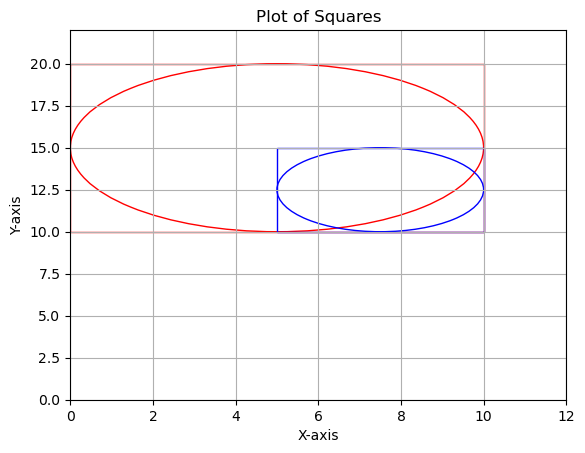

In [164]:
square1 = [0,10,10,20]
square2 = [5,10,10,15]
print(is_intersection(square1, square2))
# Extracting coordinates for each square
x_min1, y_min1, x_max1, y_max1 = square1[0], square1[2], square1[1] , square1[3]
x_min2, y_min2, x_max2, y_max2 = square2[0], square2[2], square2[1] , square2[3]
x_avg_1 = (x_min1 + x_max1) / 2
y_avg_1 = (y_min1 + y_max1) / 2
x_avg_2 = (x_min2 + x_max2) / 2
y_avg_2 = (y_min2 + y_max2) / 2
a_1=np.abs((x_min1- x_max1))
b_1=np.abs((y_min1- y_max1))
a_2=np.abs((x_min2- x_max2))
b_2=np.abs((y_min2-y_max2))
r1=a_1/2
r2=a_2/2
# Creating subplots
fig, ax = plt.subplots()
plt.grid()
# Plotting the first square
rect1 = plt.Rectangle((x_min1, y_min1), x_max1 - x_min1, y_max1 - y_min1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
circle_1=plt.Circle((x_avg_1, y_avg_1), r1, color='r', fill=False)
ax.add_artist(circle_1)
# Plotting the second square
rect2 = plt.Rectangle((x_min2, y_min2), x_max2 - x_min2, y_max2 - y_min2, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect2)
circle_2=plt.Circle((x_avg_2, y_avg_2), r2, color='b', fill=False)
ax.add_artist(circle_2)
# Set axis limits
plt.xlim(0, max(x_max1, x_max2) + 2)
plt.ylim(0, max(y_max1, y_max2) + 2)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Squares')

# Show the plot

plt.show()


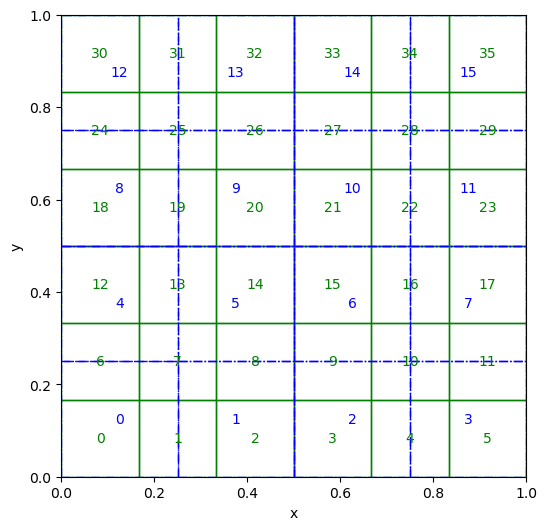

In [3]:
def draw_colored_box_boundaries(ax, rows, cols, color, linestyle='-'):
    box_width = 1.0 / cols
    box_height = 1.0 / rows

    for row in range(rows):
        for col in range(cols):
            x = col * box_width
            y = row * box_height
            if x==0 and y==0:
                fill=False
                ax.add_patch(plt.Rectangle((x, y), box_width, box_height, fill=fill, color=color, linestyle=linestyle))
            else:
                fill=False
                ax.add_patch(plt.Rectangle((x, y), box_width, box_height, fill=fill, color=color, linestyle=linestyle))
            box_num = row * cols + col
            ax.text(x + box_width / 2, y + box_height / 2, str(box_num), va='center', ha='center', color=color)
            #plt.text(0.5, 0.5, r"$\bf{IC\ points\ well\ filled}$", color="orange", fontsize=16, ha="center", va="center")
fig, ax = plt.subplots(figsize=(6, 6))


colors = ['red', 'green', 'purple', 'orange', 'cyan']
line_styles = ['-', '--', ':', '-.', '-']
#draw_colored_box_boundaries(ax, rows=10, cols=10, color='red', linestyle='-')
#draw_colored_box_boundaries(ax, rows=8, cols=8, color='orange', linestyle='--')
draw_colored_box_boundaries(ax, rows=6, cols=6, color='green', linestyle='-')
draw_colored_box_boundaries(ax, rows=4, cols=4, color='blue', linestyle='-.')
#draw_colored_box_boundaries(ax, rows=1, cols=1, color='blue', linestyle='-.')


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
#plt.gca().set_aspect('equal', adjustable='box')  

plt.show()


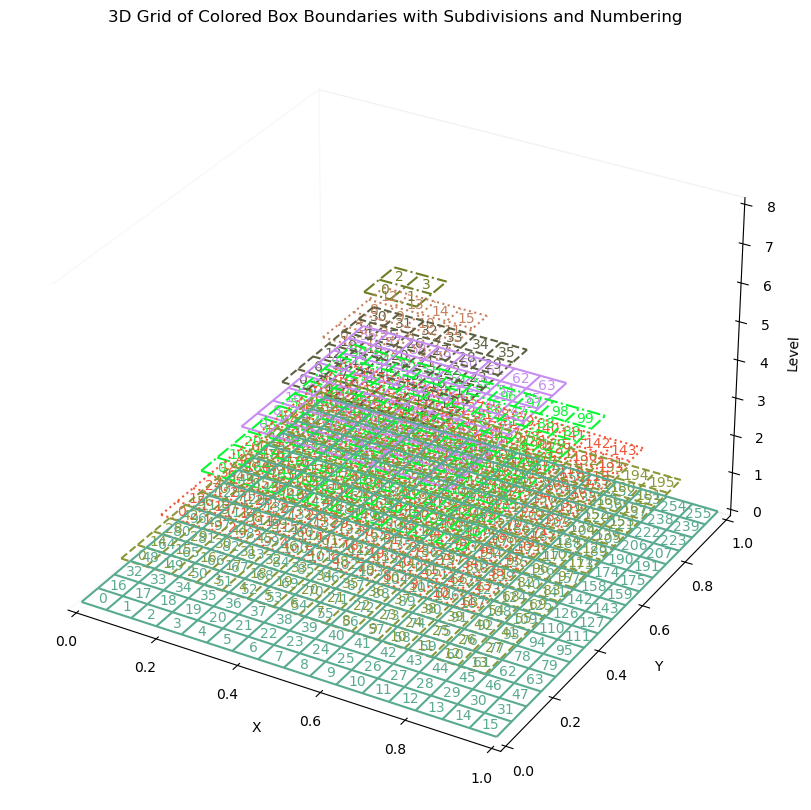

In [103]:
def draw_colored_box_boundaries(ax, x_range, y_range, z_level, color, linestyle='-', rows=10, cols=10):
    box_width = (x_range[1] - x_range[0]) / cols
    box_height = (y_range[1] - y_range[0]) / rows

    lines = []

    for row in range(rows + 1):
        y = y_range[0] + row * box_height
        lines.append([(x_range[0], y, z_level), (x_range[1], y, z_level)])

    for col in range(cols + 1):
        x = x_range[0] + col * box_width
        lines.append([(x, y_range[0], z_level), (x, y_range[1], z_level)])

    line_collection = Line3DCollection(lines, color=color, linestyle=linestyle)
    ax.add_collection3d(line_collection)

    for row in range(rows):
        for col in range(cols):
            x = x_range[0] + col * box_width
            y = y_range[0] + row * box_height
            box_num = row * cols + col
            ax.text(x + box_width / 2, y + box_height / 2, z_level, str(box_num), va='center', ha='center', color=color)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'blue', 'orange']
line_styles = ['-', '--', ':', '-.']

n_col_start = n_row_start = 16
n_col_end = n_row_end = 2

num_subdivisions = 8
z_levels = list(range(num_subdivisions))
x_ranges = [(i / n_col_start, 1 - i / n_col_start) for i in z_levels]
y_ranges = [(i / n_col_start, 1 - i / n_col_start) for i in z_levels]
x_ranges

for i, (z_level, x_range, y_range) in enumerate(zip(z_levels, x_ranges, y_ranges)):
    linestyle = line_styles[i % len(line_styles)]
    color = np.random.rand(3) 
    draw_colored_box_boundaries(ax, x_range=x_range, y_range=y_range, z_level=z_level, color=color, linestyle=linestyle, rows=n_col_start, cols=n_row_start)
    n_col_start -= 2
    n_row_start -= 2

ax.set_zlim(0, max(z_levels) + 1)
ax.grid(False)  

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Level")
ax.set_title("3D Grid of Colored Box Boundaries with Subdivisions and Numbering")

plt.show()

In [8]:
int(500 *1.05**3) /int(500 *1.05**3)

1.0

In [14]:
alpha=1
Nbr_f_pts_max_per_batch= 500 # 5000
Nbr_f_pts_min_per_batch= 250
for _ in range(2):
    alpha+=1     
    Nbr_f_pts_max_per_batch=int(1.05*Nbr_f_pts_max_per_batch)  
    Nbr_f_pts_min_per_batch=int(1.05*Nbr_f_pts_min_per_batch)  
    print(Nbr_f_pts_max_per_batch,Nbr_f_pts_min_per_batch,alpha)

525 262 2
551 275 3


In [15]:
Nbr_f_pts_max_per_batch = int(Nbr_f_pts_max_per_batch / (1.05 ** (alpha-1)))  # revert the increase
Nbr_f_pts_min_per_batch = int(Nbr_f_pts_min_per_batch / (1.05 ** (alpha-1)))  # revert the increase
print(Nbr_f_pts_max_per_batch,Nbr_f_pts_min_per_batch,alpha)

499 249 3


In [59]:
import numpy as np
import tensorflow as tf

# Generate sample data
num_samples = 10
num_features = 2
phi = np.random.rand(num_samples, num_features)
x = np.random.rand(num_samples, num_features)
phi = tf.constant(phi, dtype='float64')
x = tf.constant(x, dtype='float64')
with tf.GradientTape(persistent=True) as tape:
    tf.print("phi", phi.shape)
    
    tf.print("x.shape", x.shape)

    phi_x = tape.gradient(phi, x)

        
    tf.print("phi_x.shape", phi_x.shape)





phi TensorShape([10, 2])
x.shape TensorShape([10, 2])


AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
import tensorflow as tf

phi = tf.constant([[0.57216301331866315],
                   [0.58973358583815072],
                   [0.57216301331866315],
                   [0.51324975953493235],
                   [0.58973358583815072]], dtype=tf.float64)

x = tf.constant([[0.84845350302273703],
                 [0.83831411733031425],
                 [0.82712762154129194],
                 [0.89464855159043699],
                 [0.82712762154129194]], dtype=tf.float64)



    
with tf.GradientTape(persistent=True) as tape:
    tape.watch(phi)
    tape.watch(x)  
    phi_x = tape.gradient(phi, x)
print(phi_x)





None


In [64]:
with tf.GradientTape() as g:
  x = tf.constant([[1., 2.], [3., 4.]], dtype=tf.float64)
  g.watch(x)
  y = x * x
  print(x.shape)
  print(y.shape)
batch_jacobian = g.batch_jacobian(y, x)
batch_jacobian

(2, 2)
(2, 2)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('fallback_to_while_loop', 'iters', 'loop_fn', 'parallel_iterations', 'warn'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('fallback_to_while_loop', 'iters', 'loop_fn', 'parallel_iterations', 'warn'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


<tf.Tensor: shape=(2, 2, 2), dtype=float64, numpy=
array([[[2., 0.],
        [0., 4.]],

       [[6., 0.],
        [0., 8.]]])>

In [80]:
phi = tf.constant([0.57216301331866315,
                   0.58973358583815072,
                   0.57216301331866315,
                   0.51324975953493235,
                   0.58973358583815072], dtype=tf.float64)

x=tf.constant([[1., 2.], [3., 4.]], dtype=tf.float64)

with tf.GradientTape(
      watch_accessed_variables=False, persistent=True) as tape:
    tape.watch(x)
 
    


dy_dx = tape.gradient(x*x, x)
print(dy_dx)

None


In [24]:
import tensorflow as tf 
x = tf.constant([0.57216301331866315,
                   0.58973358583815072,
                   0.57216301331866315,
                   0.51324975953493235,
                   0.58973358583815072], dtype=tf.float64)
phi = tf.constant([0.81845350302273703,
                 0.82831411733031425,
                 0.83712762154129194,
                 0.89464855159043699,
                 0.99712762154129194], dtype=tf.float64)
print(x.shape)
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  tape.watch(phi)
  print(phi.shape)


  print(tape.gradient(phi, x))  
  del tape


(5,)
(5,)
None


In [28]:
import tensorflow as tf

# Example vectors
u = tf.constant([0.7, 0.5, 0.2, 0.9, 0.3], dtype=tf.float32)
v = tf.constant([1.2, 2.5, 0.8, 0.4, 3.0], dtype=tf.float32)

# Compute the gradient using tf.GradientTape
with tf.GradientTape(persistent=True) as tape:
    tape.watch(v)  # Watch the 'v' tensor

gradient_u_with_respect_to_v = tape.batch_jacobian (u, v)

print("u:", u)
print("v:", v)
print("Gradient of 'u' with respect to 'v':", gradient_u_with_respect_to_v)

# Clean up the resources used by the tape
del tape


ValueError: Shape (5,) must have rank at least 2

In [34]:
import tensorflow as tf

phi = tf.constant[0.57216301331866315,
                   0.58973358583815072,
                   0.57216301331866315,
                   0.51324975953493235,
                   0.58973358583815072](, dtype=tf.float64)

x = tf.constant([0.81845350302273703,
                 0.82831411733031425,
                 0.83712762154129194,
                 0.89464855159043699,
                 0.99712762154129194], dtype=tf.float64)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(phi)
    tape.watch(x)
    



    grad_phi_x = tape.gradient(phi, x)
    print(grad_phi_x)
    del tape
   


SyntaxError: invalid syntax (3646211723.py, line 7)

(6, 1) (6, 1)


AttributeError: module 'tensorflow' has no attribute 'batch_jacobian'

In [ ]:
Epoch: 0, total_loss: 5.391e-04, loss_BC: 0.000e+00, loss_IC: 3.485e-04, loss_f: 1.907e-04


In [11]:
import tensorflow as tf

y = tf.cast([0.2,
                   0.4,
                   0.6,
                   0.8], dtype=tf.float64)

x = tf.cast([0.1,
                 0.2,
                 0.3,
                 0.4], dtype=tf.float64)

x = tf.reshape(x, (-1, 1))
y = tf.reshape(y, (-1, 1))
print(x.shape,y.shape)

with tf.GradientTape() as tape:
    
    tape.watch(x)
    z=y*(x)
    tape.watch(z)
    grad_y_x = tape.gradient(z,x)
    print(grad_y_x)
del tape


(4, 1) (4, 1)
tf.Tensor(
[[0.2       ]
 [0.40000001]
 [0.60000002]
 [0.80000001]], shape=(4, 1), dtype=float64)


In [5]:
import numpy as np
np.diff(y)

array([], shape=(4, 0), dtype=float64)

In [26]:
!python -m pip install --upgrade pip

  Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2


In [30]:
import tensorflow as tf

# Example vectors
u = tf.constant([[0.7], [0.5], [0.2], [0.9], [0.3]], dtype=tf.float32)
v = tf.constant([[1.2], [2.5], [0.8], [0.4], [3.0]], dtype=tf.float32)

# Define a function that computes u using v
def compute_u(v):
    return v ** 2

# Compute the batch Jacobian using tf.autodiff.batch_jacobian()
jacobian = tf.autodiff.batch_jacobian(compute_u, v)

print("u:\n", u)
print("v:\n", v)
print("Batch Jacobian of 'u' with respect to 'v':\n", jacobian)


AttributeError: module 'tensorflow._api.v2.autodiff' has no attribute 'batch_jacobian'

In [39]:
import tensorflow as tf

phi = tf.constant([[0.7],
                   [0.5],
                   [0.2],
                   [0.9],
                   [0.3]], dtype=tf.float64)

x = tf.constant([[1.2],
                 [2.5],
                 [0.8],
                 [0.4],
                 [3.0]], dtype=tf.float64)



with tf.GradientTape() as tape:
    tape.watch(phi)
    tape.watch(x)


grad_phi_x = tape.batch_jacobian(2*x, x)
print(grad_phi_x)


tf.Tensor(
[[[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]], shape=(5, 1, 1), dtype=float64)


In [6]:
pinns_below_avg=[1,2,3]
idx_pinn=0
target_idx_values = [target_idx for target_idx in pinns_below_avg]
differences = [abs(idx_pinn - idx) for idx in target_idx_values]
nearest_index = differences.index(min(differences))
print(nearest_index)

0


In [7]:
pinns_below_avg = [1, 2, 3]
idx_pinn = 0
differences = [abs(idx_pinn - idx) for idx in pinns_below_avg]
nearest_element = pinns_below_avg[differences.index(min(differences))]
print(nearest_element)


1


In [24]:
import numpy as np

N_batches = 16
matrix_size = int(np.sqrt(N_batches))

# Create a square matrix containing indices
matrix = np.arange(N_batches).reshape(matrix_size, matrix_size)

print(matrix)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [25]:
import numpy as np

N_batches = 36
matrix_size = int(np.sqrt(N_batches))

# Create a square matrix containing indices
matrix = np.arange(N_batches).reshape(matrix_size, matrix_size)

# Divide the matrix into four quarters
quarter1 = matrix[:matrix_size//2, :matrix_size//2]
quarter2 = matrix[:matrix_size//2, matrix_size//2:]
quarter3 = matrix[matrix_size//2:, :matrix_size//2]
quarter4 = matrix[matrix_size//2:, matrix_size//2:]

# Print the indices of each quarter as single lists
print("Quarter 1 Indices:")
print(quarter1.flatten())

print("\nQuarter 2 Indices:")
print(quarter2.flatten())

print("\nQuarter 3 Indices:")
print(quarter3.flatten())

print("\nQuarter 4 Indices:")
print(quarter4.flatten())


Quarter 1 Indices:
[ 0  1  2  6  7  8 12 13 14]

Quarter 2 Indices:
[ 3  4  5  9 10 11 15 16 17]

Quarter 3 Indices:
[18 19 20 24 25 26 30 31 32]

Quarter 4 Indices:
[21 22 23 27 28 29 33 34 35]


In [3]:
quarter1[0]

array([0, 1])

Cuda

In [ ]:
import numpy as np

def add_arrays(a, b):
    return a + b

# Main program
if __name__ == "__main__":
    array_size = 1000000  # Size of the arrays
    a = np.random.rand(array_size).astype(np.float32)
    b = np.random.rand(array_size).astype(np.float32)

    result = add_arrays(a, b)


# GPU

In [2]:
pip install jaxlib

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for jaxlib from https://files.pythonhosted.org/packages/62/a1/beb609f27603cf2ce6f3fb14ad2e93bde9324158f872e46509d52b178cdc/jaxlib-0.4.14-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 14.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow

In [ ]:
pip install --upgrade tensorflow

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [8]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import sys

import tensorflow.keras
import pandas as pd
#import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
#print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
#print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.13.0

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Pandas 1.5.3
GPU is NOT AVAILABLE


In [2]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

2023-09-11 11:58:37.332466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-11 11:58:37.332846: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


False

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
import tensorflow as tf

# Specify the GPU device you want to use (e.g., GPU 0)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [5]:
pip install tensorflow-gpu

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-o37jxhf2/tensorflow-gpu_6ca9aafd077e4d71b8c068f4c7ced540/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/ten